In [6]:
# Import Libraries 
# ----------------------------------------------
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Parameter Configuration 
# -----------------------
nx   = 200          # number of grid points in x-direction
nz   = nx           # number of grid points in z-direction
# Note: regular 2D grid, dz = dx
dx   = 1.           # grid point distance in x-direction
dz   = dx           # grid point distance in z-direction
c0   = 580.         # wave velocity in medium (m/s)
isx  = 105          # source location in grid in x-direction
isz  = isx          # source location in grid in z-direction
#irx  = 200          # receiver location in grid in x-direction
#irz  = isz          # receiver location in grid in z-direction
nt   = 102          # maximum number of time steps
dt   = 0.0010       # time step
f0   = 150. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift
nop   = 3            # length of finite-difference operator (3 or 5)
isnap = 50    # snapshot frequency

# Receiver locations
irx = np.array([20,60, 100, 140, 180])
irz = np.array([5, 5, 5, 5, 5])
seis = np.zeros((len(irx), nt))

print('Source frequency =', f0, 'Hz')

# CFL Stability Criterion
# -----------------------
eps  = c0 * dt / dx # epsilon value
print('Stability criterion =', eps)

# Initialize pressure at different time steps and the second
# derivatives in each direction
## -------------------------
p    = np.zeros((nz, nx, nt)) # p at time n (now)
d2px = np.zeros((nz, nx, nt)) # 2nd space derivative of p in x-direction
d2pz = np.zeros((nz, nx, nt)) # 2nd space derivative of p in z-direction


Source frequency = 150.0 Hz
Stability criterion = 0.58


In [8]:
# Initialize Velocity Model (assume homogeneous model)
# ----------------------------------------------------
c    = np.zeros((nz, nx))
c    = c + c0             # initialize wave velocity in model

# Initialize Grid
x    = np.arange(nx)
x    = x * dx             # coordinate in x-direction
z    = np.arange(nz)
z    = z * dz             # coordinate in z-direction

# Initialize Source Time Function 
# -------------------------
# Source time function (Gaussian)
# -------------------------------
src  = np.zeros(nt)
time = np.linspace(0 * dt, nt * dt, nt)
# 1st derivative of a Gaussian
src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(-1.0 * (f0 ** 2) * (time - t0) ** 2))

# Analytical Solution 
# -------------------
#G    = time * 0.
#r    = np.sqrt((x[isx] - x[irx]) ** 2 + (z[isz] - z[irz]) ** 2)

#for it in range(nt): # Calculate Green's function
#    if ((time[it] - np.abs(x[irx] - x[isx]) / c0) >= 0):
#        G[it] = (1. / (2 * np.pi * c0 ** 2))         * (1. / np.sqrt((time[it] ** 2) - (r ** 2 / (c0 ** 2))))
#Gc   = np.convolve(G, src * dt)
#Gc   = Gc[0:nt]
#lim  = Gc.max() # get limit value from maximum amplitude of analytical solution

<IPython.core.display.Javascript object>


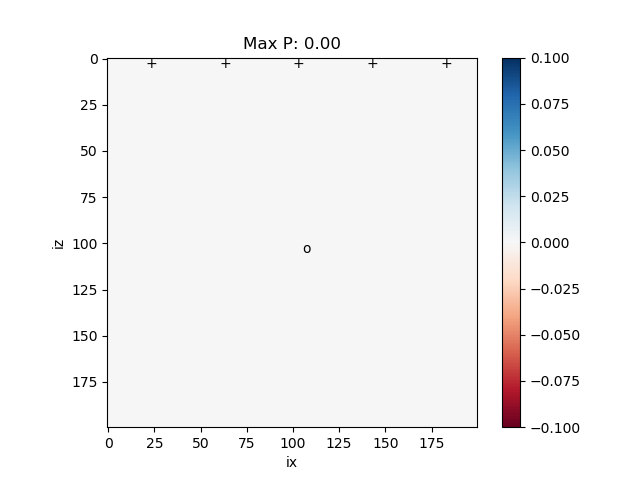

In [9]:
# Plot preparation

v = max([np.abs(src.min()), np.abs(src.max())])
# Initialize animated plot
pnew=p[:,:,0]
image = plt.imshow(pnew, interpolation='nearest', animated=True, cmap=plt.cm.RdBu)


# Plot the receivers
for x, z in zip(irx, irz):
    plt.text(x, z, '+')

plt.text(isx, isz, 'o')
plt.colorbar()
plt.xlabel('ix')
plt.ylabel('iz')


plt.ion()
#plt.show(block=False)

# required for seismograms
ir = np.arange(len(irx))

In [10]:
# Time extrapolation
for it in range(nt-1):
    if nop==3:
        # calculate partial derivatives, be careful around the boundaries
        for i in range(1, nx - 1):
            d2pz[i, :,it] = (p[i - 1, :,it] - 2 * p[i, :,it] + p[i + 1, :,it]) / dx ** 2 
        for j in range(1, nz - 1):
            d2px[:, j,it] = (p[:, j - 1,it] - 2 * p[:, j,it] + p[:, j + 1,it]) / dz ** 2

    if nop==5:
        # calculate partial derivatives, be careful around the boundaries
        for i in range(2, nx - 2):
            pzz[:, i] = -1./12*p[:,i+2]+4./3*p[:,i+1]-5./2*p[:,i]+4./3*p[:,i-1]-1./12*p[:,i-2]
        for j in range(2, nz - 2):
            pxx[j, :] = -1./12*p[j+2,:]+4./3*p[j+1,:]-5./2*p[j,:]+4./3*p[j-1,:]-1./12*p[j-2,:]
                    
            
#    pxx /= dx ** 2
#    pzz /= dx ** 2

    # Time Extrapolation
    # ------------------
    p[:,:,it+1] = 2 * p[:,:,it] - p[:,:,it-1] + (c ** 2) * (dt ** 2) * (d2pz[:,:,it] + d2px[:,:,it])
    
    # Add Source Term at isz and isx
    # ------------------------------
    # Absolute pressure w.r.t analytical solution
    p[isz, isx,it+1] = p[isz, isx,it+1] + src[it] / (dx * dz) * (dt ** 2)
    pnew=p[:,:,it]
    
    # Plot every isnap-th iteration
    if it % isnap == 0:    # you can change the speed of the plot by increasing the plotting interval
        
        plt.title("Max P: %.2f" % p.max())
        image.set_data(pnew)
        plt.gcf().canvas.draw()

#    pold, p = p, pnew

    # Save seismograms
    seis[ir, it] = p[irz[ir], irx[ir],it]

<IPython.core.display.Javascript object>


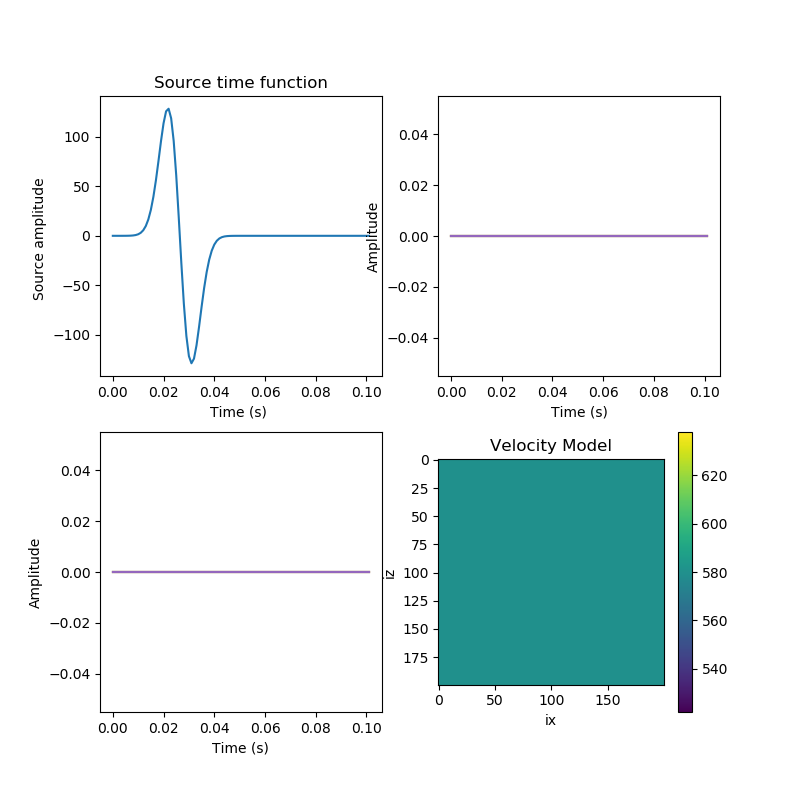

In [11]:
# Plot the source time function and the seismograms 

plt.ioff()
plt.figure(figsize=(8, 8))

plt.subplot(221)
time = np.arange(nt) * dt
plt.plot(time, src)
plt.title('Source time function')
plt.xlabel('Time (s) ')
plt.ylabel('Source amplitude ')

plt.subplot(222)
ymax = seis.ravel().max()  
for ir in range(len(seis)):
    plt.plot(time, seis[ir, :] + ymax * ir)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.subplot(223)
ymax = seis.ravel().max()
for ir in range(len(seis)):
    plt.plot(time, seis[ir, :] + ymax * ir)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.subplot(224)
# The velocity model is influenced by the Earth model above
plt.title('Velocity Model')
plt.imshow(c)
plt.xlabel('ix')
plt.ylabel('iz')
plt.colorbar()

plt.show()